In [1]:
import time
import sqlite3
import numpy as np
import pandas as pd
import datetime
import seaborn as sns #conf matrix
import datetime
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report  #conf matrix
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from time import time

warnings.filterwarnings("ignore")

# 1. DATA ANALYSIS

The first step is to extract, transform and structure the data and search for possible null or not defined values. Moreover, the text/categorical data will be converted into numerical data as most of the algorithms perform better with numerical inputs. Also, the date values will be converted so can be read for python.

In [2]:
cn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", cn)
df_aux = df
df_aux

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
49015,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
49016,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
49017,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
49018,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None


In [3]:
def fix_date(date): 
    """
        This function changes the date and fixes its format.
        It is necessary to use this function because sometimes the pd.to_datetime function converts the years wrong.
    """
    if date.year > 2021:
        year = date.year - 100
    else:
        year = date.year
    return datetime.date(int(year),date.month,date.day)

#change date format
df_aux['date'] = pd.to_datetime(df_aux['date']).dt.date
#fix date
df_aux['date'] = df_aux['date'].apply(fix_date)

df_aux

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,1929-02-10,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,1929-02-10,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,1929-02-10,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,1929-02-10,None,Donostia,Athletic,1:1
4,1928-1929,1,1,1929-02-12,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
49015,2021-2022,2,42,1922-05-29,None,Real Oviedo,UD Ibiza,None
49016,2021-2022,2,42,1922-05-29,None,Real Sociedad B,Real Zaragoza,None
49017,2021-2022,2,42,1922-05-29,None,Sporting Gijón,UD Las Palmas,None
49018,2021-2022,2,42,1922-05-29,None,CD Tenerife,FC Cartagena,None


In [4]:
# Search for the winner team
def parse_score(score):
    """ 
        This function tells who won as a function of the score.
    """
    w = ''
    if score:
        score = score.split(':')
        if score[0] > score[1]:
            w = 1
        elif score[0] < score[1]:
            w = 2
        elif score[0] == score[1]:
            w = 0
    else:
        w = 'Unknown'
    return w

# Match results
scores = df_aux['score'].values
scores = [x.split(':') if x else [-1, -1] for x in scores]
df_aux['Result'] = df_aux['score'].apply(parse_score)

In [5]:
#Home goals and away goals
home_goals = []
away_goals = []

for scored_goals in scores:
    home_goals.append(scored_goals[0])
    away_goals.append(scored_goals[1])
    
df_aux['home_goals'] = pd.to_numeric(home_goals)
df_aux['away_goals'] = pd.to_numeric(away_goals)

In [6]:
# Goal difference
df_aux['goal_difference'] = abs(df_aux['home_goals'] - df_aux['away_goals'])
df_aux['total_goals'] = df_aux['home_goals'] + df_aux['away_goals']

In [7]:
#Assigning values to each team in order of aparison (encode the label)
teams = df_aux['home_team'].drop_duplicates().values
df_aux['home_id'] = 0
df_aux['away_id'] = 0
df_aux
for i in range(len(teams)):
    df_aux.loc[df_aux['home_team'] == teams[i], ['home_id']] = i
    df_aux.loc[df_aux['away_team'] == teams[i], ['away_id']] = i

#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['Result'])
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['date'])
#reset index after droping the unknown
df_aux.reset_index(drop=True, inplace=True) 

### SEARCH FOR FEATURES

To be able to predict what will happen in a match, it is necessary to look for variables (features) that help to predict its result. This features can be obtained with data of the teams performance in the last matches. In order to do this, when a team plays on certain date, the code will provide an average of all the available variables of the n matches before that one.

In order to achieve the best precision, the features chosen are the following. 

On the one hand, it is considered the last direct matches between the two teams facing each other. 

On the other hand, as it is possible that the two teams played a long time ago, the last matches played by each team separately are also taken into account.

As for some teams there is no previous data, the rows with missing values will be dropped. This can happen as a consequence of previous divison relegation or promotion, or because there is no previously data in the dataset.

In [8]:
# new columns for features

#last direct matches
df_aux['FHG_dm'] = np.nan #Feature home goals
df_aux['FAG_dm'] = np.nan #Feature away goals
df_aux['FTG_dm'] = np.nan #Feature total goals
df_aux['FDG_dm'] = np.nan #Feature difference goals
df_aux['VHT_dm'] = np.nan #victories home team
df_aux['VAT_dm'] = np.nan #victories away team

#last matches of each team separeately
df_aux['FHG'] = np.nan #Feature home goals
df_aux['FAG'] = np.nan #Feature away goals
df_aux['VHT'] = np.nan #victories home team
df_aux['VAT'] = np.nan #victories away team

In [9]:
def last_dir_matches(df,row,num):
    """
        This function gets features for the last num direct matches.
    """
    
    h_t = row['home_id']
    a_t = row['away_id']
    date = row['date']
    
    #get all direct matches
    matches = df[((df['home_id']== h_t) & (df['away_id'] == a_t )) 
                 | ((df['home_id']== a_t) & (df['away_id'] == h_t))]
    
    #get last matches of direct matches
    last_matches = matches[matches['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    if (len(last_matches) == num):
        
    #columns of total goals, away goals, home goals, diference goals, home victories and away victories
        total_goals = last_matches['total_goals'].sum()
        diff_goals = last_matches['goal_difference'].sum()
        
        team_home_hg = last_matches['home_goals'][last_matches['home_id'] == h_t].sum() 
        team_home_ag = last_matches['away_goals'][last_matches['away_id'] == h_t].sum()
        team_away_hg = last_matches['home_goals'][last_matches['home_id'] == a_t].sum()
        team_away_ag = last_matches['away_goals'][last_matches['away_id'] == a_t].sum()
        
        team_home_vh = (last_matches['Result'] == 1)[last_matches['home_id'] == h_t].sum(axis=0)
        team_home_va = (last_matches['Result'] == 2)[last_matches['away_id'] == h_t].sum(axis=0)
        team_away_vh = (last_matches['Result'] == 2)[last_matches['away_id'] == a_t].sum(axis=0)
        team_away_va = (last_matches['Result'] == 1)[last_matches['home_id'] == a_t].sum(axis=0)
        
        row['FTG_dm'] = int(total_goals)
        row['FDG_dm'] = int(diff_goals)
        row['FHG_dm'] = int(team_home_hg + team_home_ag)
        row['FAG_dm'] = int(team_away_hg + team_away_ag)
        row['VHT_dm'] = int(team_home_vh + team_home_va)
        row['VAT_dm'] = int(team_away_vh + team_away_va)
        
    return row

In [10]:
def last_matches(df,row,num):
    """
        This function gets features for the last num matches for each team.
    """
    
    h_t = row['home_id']
    a_t = row['away_id']
    date = row['date']
    
    #get all matches of each team
    matches_h = df[(df['home_id'] == h_t) | (df['away_id'] == h_t )]
    matches_a = df[(df['home_id'] == a_t) | (df['away_id'] == a_t )]
    
    #get last matches of each team
    last_matches_h = matches_h[matches_h['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    last_matches_a = matches_a[matches_a['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    
    if ((len(last_matches_h) == num) and (len(last_matches_a) == num)):
        
        #column of away goals, home goals, home victories, away victories
        team_home_hg = last_matches_h['home_goals'][last_matches_h['home_id'] == h_t].sum() 
        team_home_ag = last_matches_h['away_goals'][last_matches_h['away_id'] == h_t].sum()
        team_away_hg = last_matches_a['home_goals'][last_matches_a['home_id'] == a_t].sum()
        team_away_ag = last_matches_a['away_goals'][last_matches_a['away_id'] == a_t].sum()
        
        team_home_vh = (last_matches_h['Result'] == 1)[last_matches_h['home_id'] == h_t].sum(axis=0)
        team_home_va = (last_matches_h['Result'] == 2)[last_matches_h['away_id'] == h_t].sum(axis=0)
        team_away_vh = (last_matches_a['Result'] == 2)[last_matches_a['away_id'] == a_t].sum(axis=0)
        team_away_va = (last_matches_a['Result'] == 1)[last_matches_a['home_id'] == a_t].sum(axis=0)
        
        row['FHG'] = int(team_home_hg + team_home_ag)
        row['FAG'] = int(team_away_hg + team_away_ag)
        row['VHT'] = int(team_home_vh + team_home_va)
        row['VAT'] = int(team_away_vh + team_away_va)
        
    return row

In [11]:
# Features obtained from the last 5 matches of each team
num = 5
df_aux = df_aux.apply(lambda row: last_matches(df_aux, row, num), axis=1)

In [12]:
# Features obtained from the last 7 matches of each team
num = 7
df_aux = df_aux.apply(lambda row: last_dir_matches(df_aux, row, num), axis=1)

In [13]:
# dropping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['FHG_dm'])
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['FHG'])

# reset index after droping the unknown
df_aux.reset_index(drop=True, inplace=True)

# changing types
df_aux['FHG_dm'] = df_aux['FHG_dm'].astype('int')
df_aux['FAG_dm'] = df_aux['FAG_dm'].astype('int')
df_aux['FTG_dm'] = df_aux['FTG_dm'].astype('int')
df_aux['FDG_dm'] = df_aux['FDG_dm'].astype('int')
df_aux['VHT_dm'] = df_aux['VHT_dm'].astype('int')
df_aux['VAT_dm'] = df_aux['VAT_dm'].astype('int')
df_aux['FHG'] = df_aux['FHG'].astype('int')
df_aux['FAG'] = df_aux['FAG'].astype('int')
df_aux['VAT'] = df_aux['VAT'].astype('int')
df_aux['VHT'] = df_aux['VHT'].astype('int')

df_aux

,season,division,matchday,date,time,home_team,away_team,score,Result,home_goals,...,FHG_dm,FAG_dm,FTG_dm,FDG_dm,VHT_dm,VAT_dm,FHG,FAG,VHT,VAT
0,1931-1932,1,10,1932-02-07,None,Donostia,Arenas Club,7:0,1,7,...,16,16,32,12,3,3,7,9,1,1
1,1931-1932,1,10,1932-02-07,None,Barcelona,Real Unión,3:2,1,3,...,22,10,32,12,6,0,12,7,3,2
2,1931-1932,1,10,1932-02-07,None,Athletic,Real Madrid,3:3,0,3,...,17,13,30,16,4,2,12,10,3,3
3,1931-1932,1,11,1932-02-14,None,Arenas Club,Barcelona,1:3,2,1,...,11,14,25,13,1,4,7,11,1,3
4,1931-1932,1,11,1932-02-14,None,Real Madrid,Donostia,1:0,1,1,...,12,14,26,10,3,3,11,9,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28595,2021-2022,2,3,2021-08-27,8:00 PM,UD Las Palmas,SD Huesca,2:1,1,2,...,6,8,14,10,1,4,5,5,2,3
28596,2021-2022,2,3,2021-08-28,5:00 PM,Sporting Gijón,CD Mirandés,2:1,1,2,...,10,7,17,7,2,2,2,3,2,1
28597,2021-2022,2,3,2021-08-28,7:30 PM,Real Oviedo,CD Tenerife,0:0,0,0,...,11,9,20,8,4,2,7,5,0,1
28598,2021-2022,2,3,2021-08-28,10:00 PM,Ponferradina,Girona,2:1,1,2,...,6,12,18,12,1,4,5,5,2,3


## 2. FEATURE SELECTION

All of the features found might not be useful in building a machine learning model to make the predictions, moreover, some of the features might even make the predictions worse. For this reason, in this section a subset of relevant features will be selected and used in this model. 

home_id and away_id have been discarted as features because label encoding induces the following problem. As it uses number sequencing it can cause a comparison between them, this means that the algorithm misunderstand the data and treat it as some kind of order, giving more weight to the teams with higher ids. An alternative procedure is One-Hot Encoding, but due to the amount of teams this would not be efficient.

In order to do this feature selection, different methods have been used.

In [14]:
y = df_aux['Result'].astype('int')
features = ['FHG_dm','FAG_dm','FTG_dm','FDG_dm','VHT_dm','VAT_dm','FHG','FAG','VHT','VAT']
X = df_aux[features].astype('int')
num_features = 4

### Pearson correlation

The absolute value of the Pearson's correlation between the target and features is calculated. Giving a value between -1 and 1 that indicates the linear correlation between each variable and the result. This method is a filter-based method.

* A value closer to 0 implies weaker correlation (exact 0 implies no correlation)
* A value closer to 1 implies stronger positive correlation
* A value closer to -1 implies stronger negative correlation

The top n features with value closer to 1 will be used.

In [15]:
def Pearson_select(X, y, num_features):
    """
        This function selects the "num_features" features with smallest
        correlation with the other ones.
    """
    
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation for each feature
    for i in feature_name:
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        
    # feature name
    feature_selection = X.iloc[:,np.argsort(np.abs(cor_list))[-num_features:]].columns.tolist()
    
    # feature selection
    cor_support = [True if i in feature_selection else False for i in feature_name]
    
    return cor_list, feature_selection

cor_list, feature_selection = Pearson_select(X, y, num_features)
print('Features selected: ', feature_selection)
print('Correlations of features: ', cor_list)

Features selected:  ['VHT_dm', 'VAT_dm', 'FAG', 'FAG_dm']
Correlations of features:  [-0.020080234363418194, 0.07466513057012698, 0.04029223296368744, 0.03631943129203537, -0.04602250016483274, 0.053785114510317505, 0.0038806873209110463, 0.06500003371570405, -0.021424027938102195, 0.04304510379590489]


### Chi-Square

This is another filter-based method. In this method, the chi-square metric between the target and the numerical variable is calculated and the variables with the maximum chi-squared values are selected.

In [16]:
# Normalayzing X
X_norm = MinMaxScaler().fit_transform(X)

# Computing Chi
chi_selector = SelectKBest(chi2, k=num_features)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

print(str(len(chi_feature)), 'selected features')
print(chi_feature)

4 selected features
['FHG_dm', 'VHT_dm', 'VAT_dm', 'VHT']


### Recursive Feature Elimination

This is a wrapper based method which consist on selecting features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features. Then, the least important ones are eliminated from the current set. This procedure is recursively repeated until the desired number of features is reached. In this case the Logistic Regression has been used as the estimator.

In [17]:
rfe_selector = RFE(estimator=LogisticRegression(multi_class='ovr', max_iter=500, class_weight="balanced"), 
                   n_features_to_select=num_features, step=30, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

print('selected features:',str(len(rfe_feature)))
print(rfe_feature)

Fitting estimator with 10 features.
selected features: 4
['FHG_dm', 'FAG_dm', 'FHG', 'FAG']


# 3. SPLIT DATA

In order to train and test the model the data has been randomly split, using the library ”train test split” from scikit-learn. The split used is 80% training and 20% test. 

In [18]:
features = ['FHG_dm', 'FAG_dm', 'FHG', 'FAG']
target = 'Result'
X = df_aux[features]
y = df_aux[target]

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = X_train.astype('int')
X_test = X_test.astype('int')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

#size
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (22880, 4)
X_test shape: (5720, 4)
y_train shape: (22880,)
y_test shape: (5720,)


# 4. MODEL AND METRICS

While training the model, the data was found to be unbalanced, meaning that the number of times the target variable appears was very different from the others. In this case, the number of times that the "home team won" was, by far, higher than "tie" or "home team lose". When this happens, the algorithm learns that a particular class is more common, inducing a bias towards it because predicting the majority models would score high in accuracy. However, when this happens the model is not great. It assigns the same class to all the observations and does not generalize well.

In order to fix it, a penalized model has been used. Usually, algorithms treat all misclassifications in the same way. Then, the idea is to penalize misclassifications from the majority class more than the minority. These penalties help the model to improve the predictions of the minority class.

In order to evaluate the model, a metric has to be chosen. When the data is unbalanced using accuracy as a metric is never a good idea. For this reason, precision, recall, and F1-Score (a combination of both, recall and precision) are used also to review the obtained results. 
* Precision: How accurate the positive predictions are.
* Recall: Coverage of actual positive sample.

In [19]:
def train_test(model, X_train, y_train, X_test, y_test):
    """
        General function that trains a model and makes the predictions.
        This function also evaluates the model using a given metric.
    """
    #TRAIN
    start = time()
    model.fit(X_train, y_train)
    end = time()
    t = end - start
    print("The model has been trained in {:2f} seconds".format(t))
    
    #PREDICTIONS
    start = time()
    y_pred = model.predict(X_test)
    end = time()
    t = end - start
    print("The predictions have been made in {:2f} seconds".format(t))
    
    labels = ['Tie', 'Home win', 'Away Win']
    
    #METRICS
    print(metrics.classification_report(y_test, y_pred, target_names=labels))
    print("F1 Score: ", metrics.f1_score(y_test, y_pred, average='macro'))
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("Recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Precision: ", metrics.precision_score(y_test, y_pred, average='macro'))
    
    return y_pred
    

### Logistic Regression

The chosen model has been logistic regression, which uses an equation similar to linear regression, where the inputs are combined linearly using weights or coefficient values to predict the output value. Logistic regressions are binary classifiers, this means that they cannot handle outputs with more than two classes. In this project, as there are 3 classes, the one-vs-rest logistic regression (OVR) extension has been used. It assumes that each classification problem is independent. In one-vs-rest logistic regression a separate model is trained for each class predicted whether an observation is that class or not (thus making a binary classification problem).

In [20]:
lr = LogisticRegression(multi_class='ovr', max_iter=300,class_weight="balanced")

In [21]:
print("Logistic Regression:")
y_pred_lr = train_test(lr, X_train, y_train, X_test, y_test)

Logistic Regression:
The model has been trained in 0.095234 seconds
The predictions have been made in 0.001955 seconds
              precision    recall  f1-score   support

         Tie       0.30      0.26      0.28      1477
    Home win       0.62      0.52      0.57      2982
    Away Win       0.31      0.47      0.37      1261

    accuracy                           0.44      5720
   macro avg       0.41      0.42      0.41      5720
weighted avg       0.47      0.44      0.45      5720

F1 Score:  0.4067674527153951
Accuracy:  0.4433566433566434
Recall:  0.4181760701125092
Precision:  0.40973742610673664


# 5. ANALYSIS OF THE RESULTS

### Confusion matrix

By plotting the confusion matrix, the relation between actual and predicted results can be seen easily. It shows the relation between predicted and real values in a matrix. It can be seen that the model does a pretty good job in predicting home wins and a moderate job in predicting "Away Win". However, the worst predictions of our model are ties.

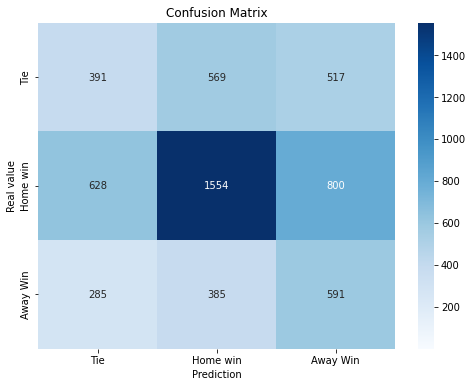

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
labels = ['Tie', 'Home win', 'Away Win']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues",vmin = 0.2)
plt.title('Confusion Matrix')
plt.ylabel('Real value')
plt.xlabel('Prediction')
plt.show()

### Actual result, well prediction, bad prediction

Similarly to the confusion matrix, plotting as a bar diagram can also be helpful to see the effectiveness of the model.
Here it can be see again that the worst predictions of the model are ties (there are much more bad predictions than good ones).

In [23]:
index = X_test.index
df_pred = df_aux.loc[index]
df_pred['prediction'] = y_pred_lr
columns = ['season','division','matchday','date','home_team','away_team','Result','prediction']
df_pred = df_pred[columns]

In [24]:
result = df_pred['Result'].value_counts()
pred = df_pred[['prediction','Result']]
good_pred = pred[pred['prediction'] == pred['Result']].value_counts()
good_pred.reset_index(drop=True, inplace=True, level='Result')

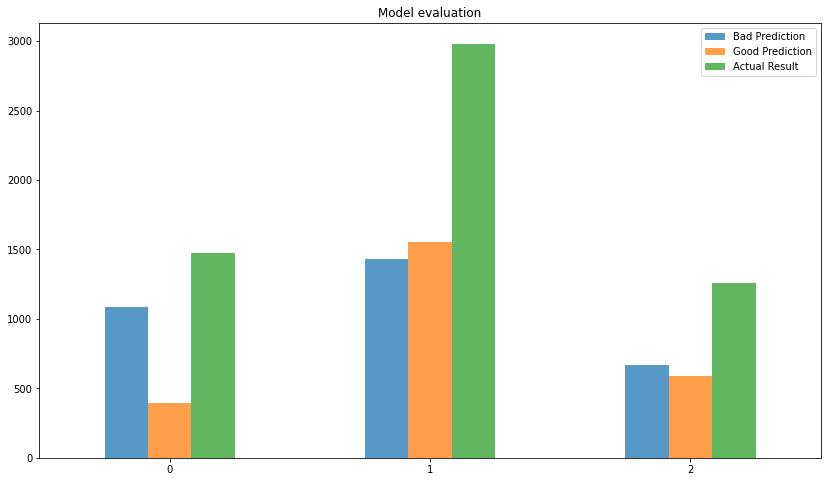

In [25]:
bad_pred = pred[(pred['prediction'] != pred['Result'])].groupby('Result').count()
bad_pred = bad_pred['prediction']
evaluation = pd.concat([bad_pred, good_pred,result], axis=1, 
                       keys=['Bad Prediction','Good Prediction','Actual Result']
                      ).plot(kind='bar', figsize=(14,8), title="Model evaluation", alpha=0.75, rot=0)

### Analysis of failures and successes

Another way to evaluate the model is looking for the incorrectly predicted values. This procedure let us know if there is a bias towards a specific value. In this case, it was really helpful to see that if the bias is not treated correctly, in some cases, ties were never predicted.

Result        0     1    2
prediction                
0           391   628  285
1           569  1554  385
2           517   800  591


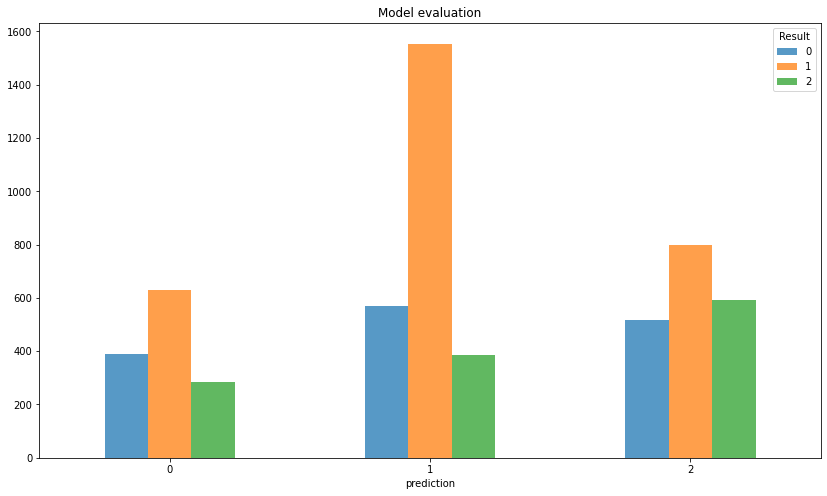

In [26]:
fail_suc = pred[(pred['prediction'] != pred['Result']) | 
                (pred['prediction'] == pred['Result']) ].value_counts()
fail_suc = pd.DataFrame(fail_suc)
fail_suc = fail_suc.unstack()
fail_suc[0].plot(kind='bar', figsize=(14,8), title="Model evaluation",alpha=0.75, rot=0)

print(fail_suc[0])

# 6. Conclusions

Based on the previous analysis, our model predicts quite well the results of the matches as it achieved at least 40% of accuracy, F1-score, recall and precision and, without using the algorithm, the random prediction probability of success is 33% (home win/away win/tie) so the algorithm is able to identify some patterns after all.

The 4 most important features where the home goals, the away goals for both, direct matches between both teams and matches of each team separately. It has been surprising for us that no feature selection method has selected "home wins" or "away wins" as potencial predictors.

Regarding metrics, looking for acuracy has been proved to not being the only relevant measurement, as many times can be misleading. As an example, the firs models proposed had a high accuracy, but ties were never predicted. This was a consequence of the dataset unbalance. For this reason, other metrics have also been used to evaluate the models: recall, precision, and F1-score.

In our model the F1-score, which gave the a combination of both, recall and precision, gives 0.28, 0.57 and 0.37. This means that:

* On the one hand, the model is better predicting a win for the home team. This is caused by the previously mentioned problem with the data, as most of the times home team wins. 

* On the other hand, the model fails the most in case of ties, but not as much as if we focused on accuracy.

The main cause for this difference was the amount of data disponible for each case. We have tried to fix this problem using a penalized model, but it can also be achieved by making changes to the data. This means that the model could be less biased towards the home team if the data were equally distributed. 

In conclusion, with this project we have realized that football prediction is a very hard task. For the future, we suggest to find more variables that could be useful for the prediction results as details of the players of each team, players individual performance, fouls committed, etc.
In conclusion, one can see that football predicition is a very hard task to achieve. For further improvements, a higer amount of variables would be helpful, such as details of each member of the team, the strategy used, the trainer, fouls committed, etc.


# 7. EXPORT MODEL

This only exports the last model run and the TEST

In [27]:
#Replace 0 with X
df_pred[['Result','prediction']] = df_pred[['Result','prediction']].astype(str) 
df_pred[['Result','prediction']] = df_pred[['Result','prediction']].replace('0','X')

In [28]:
shouldExport = input('Do you want to export the model(s) (y / n) ? ')
if shouldExport.strip().lower() == 'y':
    df_pred.to_excel("../models/Predictions.xlsx")

Do you want to export the model(s) (y / n) ? y
